# nanoporeRunQC_quickRunner.ipynb
## Marcus Viscardi,    July 27, 2023

I want to generally just have this script run stuff from nanoporePipelineCommon.py, this is a notebook so I can test these a little easier!

In [14]:
import nanoporePipelineCommon as npC

import seaborn as sea
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from Bio import SeqIO
import pysam

import pandas as pd
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', None)

get_dt = npC.get_dt
print(f"Imports done at {get_dt(for_print=True)}")

Imports done at 07/02/24 @ 01:29:28 PM


In [1]:
obj_dict = {}
libs_to_run = [
    # "oldN2",
    # # "oldS6",
    # "newerN2",
    # "newerS6",
    # "newerS5",
    # "thirdN2",
    # "thirdS5",
    # "thirdS6",
    "temp25cN2",
    "temp25cS5",
    "temp25cS6",
    "temp25cS7",
    "newN2",
    "newS5",
    "newS6",
]
for lib in libs_to_run:
    print(f"\nLoading {lib}...", end="")
    obj_dict[lib] = npC.NanoporeRun(run_nickname=lib)
    print(" Done!")


Loading 25C_N2...

NameError: name 'npC' is not defined

In [16]:
def plot_tail_length_by_standard(nanopore_run_obj, save=False, show=True,
                                 y_lims=(0, 200), drop_non_standards=False,
                                 save_dir=None, plot_type="violin", violin_kwargs=None,
                                 **kwargs) -> (plt.Figure, plt.Axes):
        if not nanopore_run_obj.had_standards:
            raise ValueError(f"Run {nanopore_run_obj.run_name} did not have standards")
        if nanopore_run_obj.mergedOnReads_df is None:
            nanopore_run_obj.load_mergedOnReads()
        if "figsize" not in kwargs.keys():
            print(f"Figure size not set, using default (12, 8)")
            kwargs["figsize"] = (12, 8)

        plot_df = nanopore_run_obj.mergedOnReads_df[['assignment', 'polya_length']]
        plot_df = plot_df[~plot_df.assignment.str.contains("Ambiguous")]
        if drop_non_standards:
            plot_df = plot_df[~plot_df.assignment.str.contains("NotAStandard")]
        plot_order = ['60', '15', '10']

        fig, ax = plt.subplots(**kwargs)
        sea.set_theme(style="whitegrid")
        # fig.set_size_inches(6, 6)
        # sea.boxplot(plot_df, ax=ax,
        #             x='assignment', y='polya_length')
        if plot_type == "violin":
            sea.violinplot(plot_df, ax=ax,
                           order=plot_order,
                           x='assignment', y='polya_length',
                           inner='quartile', density_norm='width', cut=0,
                           linewidth=1, width=0.8,
                           **(violin_kwargs if violin_kwargs is not None else {}))
        elif plot_type == "box":
            sea.boxplot(plot_df, ax=ax,
                        order=plot_order,
                        x='assignment', y='polya_length')
        elif plot_type == "strip":
            sea.stripplot(plot_df, ax=ax,
                          order=plot_order,
                          x='assignment', y='polya_length')
        # elif plot_type == "swarm":
        #     sea.swarmplot(plot_df, ax=ax,
        #                   order=plot_order,
        #                   x='assignment', y='polya_length')
        else:
            raise ValueError(f"plot_type {plot_type} not recognized")
        ax.set_title(f"{nanopore_run_obj.run_nickname} Tail Lengths by Standard")
        ax.set_ylabel("Tail Length")
        ax.set_xlabel("Assigned Standard")
        ax.set_ylim(y_lims[0], y_lims[1])

        plt.tight_layout()
        if save_dir is not None:
            out_path = f"{save_dir}/{nanopore_run_obj.run_nickname}_tail_lengths_by_standard.{plot_type}"
        else:
            out_path = f"{nanopore_run_obj.run_dir}/{nanopore_run_obj.run_nickname}_tail_lengths_by_standard.{plot_type}"
        
        if save:
            fig.savefig(out_path + ".png", dpi=300)
            fig.savefig(out_path + ".svg")
        if show:
            plt.show()
        return fig, ax


Running 25C_N2...Loading 240701_mergedOnReads.plusStandards.parquet... Done. Loaded 522,716 rows.


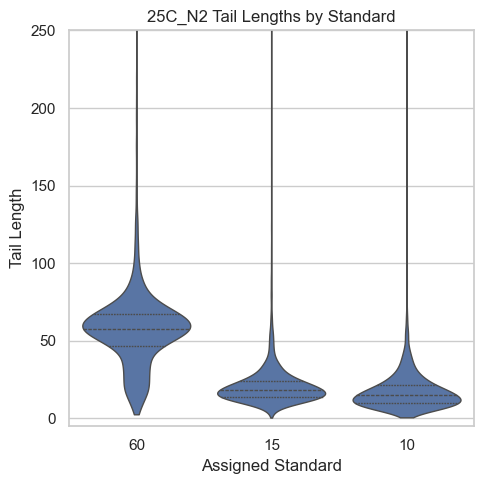

 Done!

Running 25C_S5...Loading 240701_mergedOnReads.plusStandards.parquet... Done. Loaded 803,791 rows.


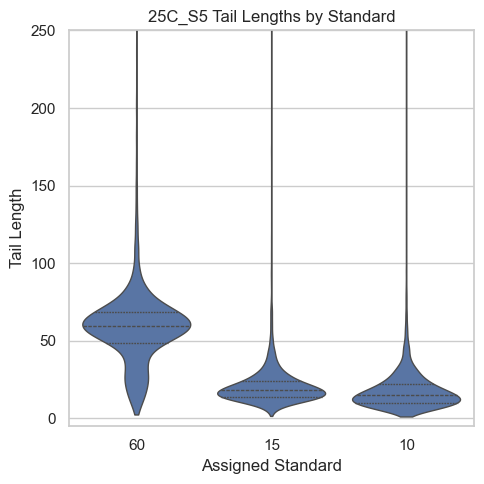

 Done!

Running 25C_S6...Loading 240701_mergedOnReads.plusStandards.parquet... Done. Loaded 774,614 rows.


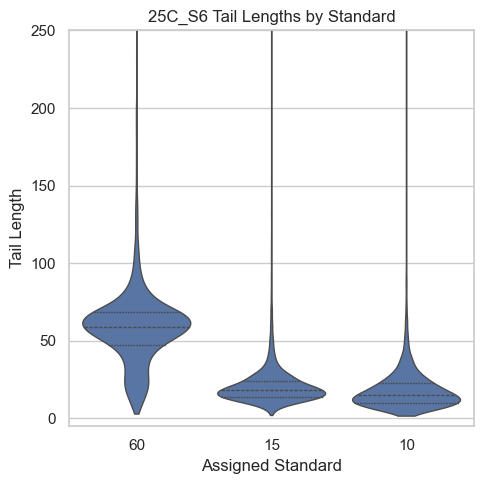

 Done!

Running 25C_S7...Loading 240701_mergedOnReads.plusStandards.parquet... Done. Loaded 521,669 rows.


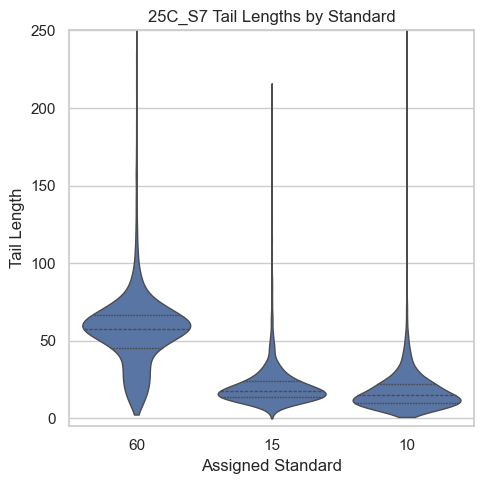

 Done!

Running newN2...ValueError for newN2: Run 5tera_xrn-1-KD_wt did not have standards
 Done!

Running newS5...ValueError for newS5: Run 5tera_xrn-1-KD_smg-5 did not have standards
 Done!

Running newS6...ValueError for newS6: Run 5tera_xrn-1-KD_smg-6 did not have standards
 Done!


In [17]:
from pathlib import Path
# super_save_dir = Path("/data16/marcus/working/240126_NanoporeRunQC_tailPlotsForJosh")
super_save_dir = Path("/data16/marcus/working/240702_NanoporeRunQC_25C")
super_save_dir.mkdir(parents=True, exist_ok=True)

test_lib = "thirdN2"
only_plot_test_lib = False

for lib, obj in obj_dict.items():
    if only_plot_test_lib and lib != test_lib:
        continue
    lib_save_dir = super_save_dir / lib
    lib_save_dir.mkdir(parents=True, exist_ok=True)
    for plot_type in ["violin", ]: # "box", "strip"]:
        print(f"\nRunning {lib}...", end="")
        try:
            plot_tail_length_by_standard(obj, drop_non_standards=True, plot_type=plot_type, save=True, save_dir=str(lib_save_dir), y_lims=(-5, 250),
                                         violin_kwargs={
                                             # "bw_adjust": 0.5,
                                             "gridsize": 1000,
                                             # "density_norm": "width",
                                         },
                                         **{
                                             "figsize": (5, 5),
                                         })
        except ValueError as e:
            print(f"ValueError for {lib}: {e}")
        print(" Done!")

In [18]:
spacing = 20

print_list = []
comma_print_list = []
for i, (lib, obj) in enumerate(obj_dict.items()):
    # I want to check that the index file is newer than the bam file
    bam = obj.cat_dir / ("cat.sorted.bam")
    bam_index = obj.cat_dir / ("cat.sorted.bam.bai")
    if not bam_index.exists() or bam_index.stat().st_mtime < bam.stat().st_mtime:
        print(f"Indexing {bam} because it's newer than it's index...")
        pysam.index(str(bam))
    
    cdict = obj.get_read_counts_dict()
    if cdict['protein_coding'] <= 0:
        print(f"Getting read biotype counts for {lib}...")
        obj.get_read_biotype_count_dict()
    if cdict['adapted'] <= 0:
        print(f"Getting raw adapted counts for {lib}...")
        obj.get_raw_adapted_count()
    cdict = obj.get_read_counts_dict()
    string_list = [f"{lib:<{spacing-5}}"]
    comma_string_list = [f"{lib},"]
    key_string_list = [f"{'Library':<{spacing-5}}"]
    key_comma_string_list = [f"{'Library'},"]
    for key, value in cdict.items():
        string_list.append(f"{value:>{spacing},}")
        comma_string_list.append(f"{value},")
        key_string_list.append(f"{key.replace('_', ' ').title():>{spacing}}")
        key_comma_string_list.append(f"{key.replace('_', ' ').title()},")
    if i == 0:
        print_list.append(key_string_list)
        comma_print_list.append(key_comma_string_list)
    print_list.append(string_list)
    comma_print_list.append(comma_string_list)
print("\n".join(["".join(line) for line in print_list]))
print("\n".join(["".join(line) for line in comma_print_list]))  # use this for pasting to google sheets

Getting read biotype counts for 25C_N2...
Getting raw adapted counts for 25C_N2...
Getting read biotype counts for 25C_S5...
Getting raw adapted counts for 25C_S5...
Getting read biotype counts for 25C_S6...
Getting raw adapted counts for 25C_S6...
Getting read biotype counts for 25C_S7...
Getting raw adapted counts for 25C_S7...
Indexing /data16/marcus/working/221216_nanoporeRun_totalRNA_wt_xrn-1-KD_5TERA/output_dir/cat_files/cat.sorted.bam because it's newer than it's index...
Getting read biotype counts for newN2...
Getting raw adapted counts for newN2...
Indexing /data16/marcus/working/221216_nanoporeRun_totalRNA_smg-5_xrn-1-KD_5TERA/output_dir/cat_files/cat.sorted.bam because it's newer than it's index...
Getting read biotype counts for newS5...
Getting raw adapted counts for newS5...
Indexing /data16/marcus/working/221216_nanoporeRun_totalRNA_smg-6_xrn-1-KD_5TERA/output_dir/cat_files/cat.sorted.bam because it's newer than it's index...
Getting read biotype counts for newS6...
Get

25C_N2


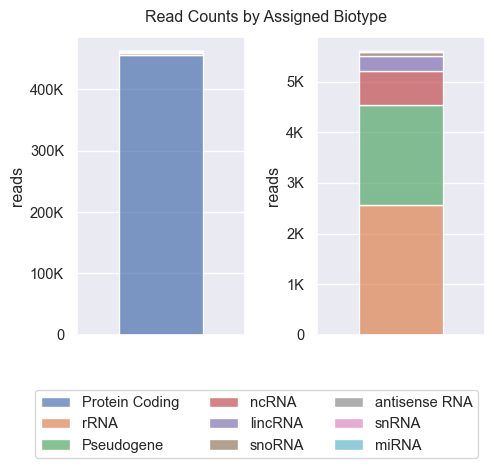

25C_S5


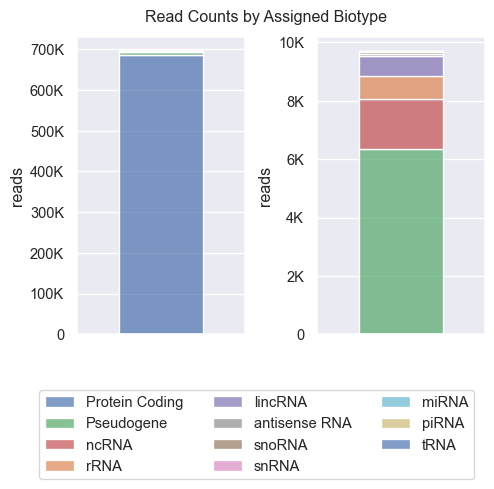

25C_S6


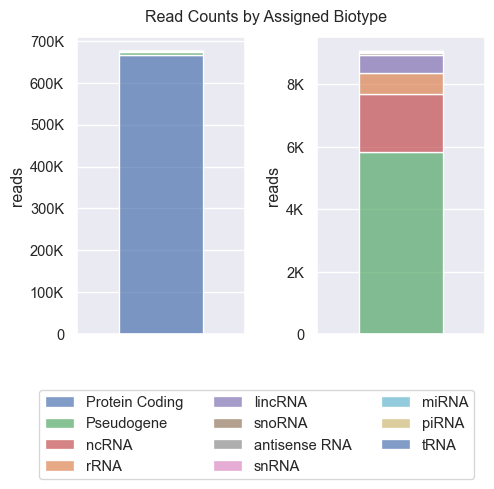

25C_S7


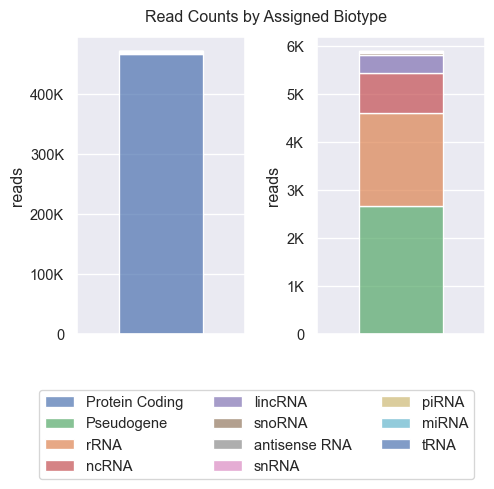

newN2


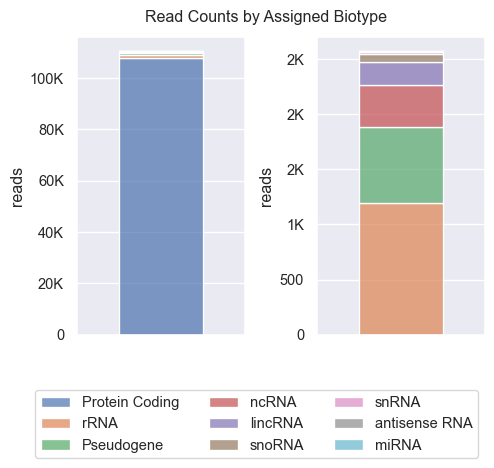

newS5


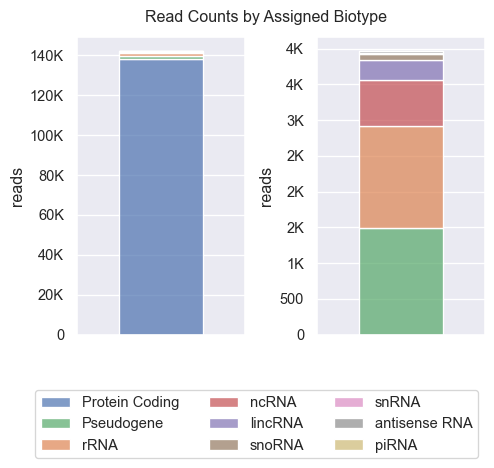

newS6


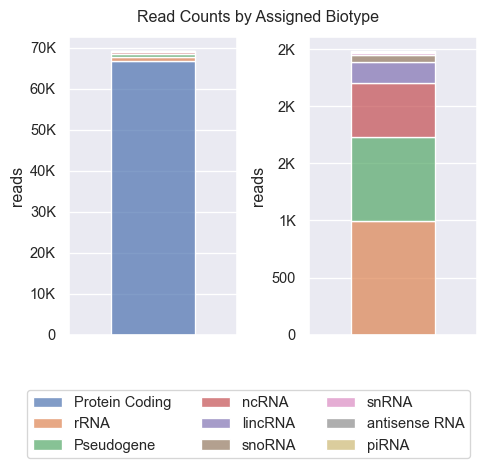

done.


In [19]:
sea.set_style('whitegrid')

for i, lib in enumerate(libs_to_run):
    lib_obj = obj_dict[lib]
    print(lib)
    lib_obj.biotypes_bar_plot()
print("done.")

In [20]:
for i, lib in enumerate(libs_to_run):
    lib_obj = obj_dict[lib]
    print(lib)
    lib_obj.print_read_counts()

25C_N2
Basecalled Reads:              630,219 100.00%
Aligned Reads:                 555,654  88.17%
Primary Aligned Reads:         527,809  83.75%
Tail Called Reads:             273,019  43.32%
Gene Assigned Reads:           462,085  73.32%
Transcript Assigned Reads:     269,309  42.73%
Standards Assigned Reads:      152,214  24.15%
Protein Coding Reads:          456,481  72.43%
Adapted Reads:                   9,169   1.45%
25C_S5
Basecalled Reads:              917,697 100.00%
Aligned Reads:                 847,085  92.31%
Primary Aligned Reads:         807,597  88.00%
Tail Called Reads:             457,351  49.84%
Gene Assigned Reads:           695,885  75.83%
Transcript Assigned Reads:     475,225  51.78%
Standards Assigned Reads:      176,204  19.20%
Protein Coding Reads:          686,178  74.77%
Adapted Reads:                   8,683   0.95%
25C_S6
Basecalled Reads:              894,679 100.00%
Aligned Reads:                 815,879  91.19%
Primary Aligned Reads:         778,504 